## 1.- Importamos el data set 
El data set se encuentra en la carpeta input, por lo que en la funcion read_csv() le doy el path relativo en el que se encuentra el fichero para que toda persona que se descargue este repositorio pueda abrirlo.
La codificacion del fichero sigue la ISO-8859-1, al pasarle como parametro esto a la funcion es capaz de abrir el fichero.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
from src.functions import changeCharacterSex, changeFatalValue, removefinalcharacters,ChangeType
data = pd.read_csv("input/GSAF5.csv", encoding = "ISO-8859-1")

## 2.- Limpieza de datos y busqueda de la Hipótesis
Elimino las columnas Unmamed: 22 y Unnamed:23 por falta de datos y nombre en la serie que permit tarabajar con esos datos.

In [3]:
print(data.isnull().sum())

Case Number                  0
Date                         0
Year                         0
Type                         0
Country                     43
Area                       402
Location                   496
Activity                   527
Name                       200
Sex                        567
Age                       2681
Injury                      27
Fatal (Y/N)                 19
Time                      3213
Species                   2934
Investigator or Source      15
pdf                          0
href formula                 1
href                         3
Case Number.1                0
Case Number.2                0
original order               0
Unnamed: 22               5991
Unnamed: 23               5990
dtype: int64


In [4]:
data = data[['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time',
       'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href',
       'Case Number.1', 'Case Number.2', 'original order']]

Compruebo los diferentes valores que pueden tomar las series de dataframe, para buscar variables categoricas y asi empezar a hacer la limpieza de esas series.

In [5]:
print(data['Type'].value_counts()) 
print(data['Fatal (Y/N)'].value_counts())
data['Sex '] = data['Sex '].fillna('UNKNOWN')
print(data['Sex '].value_counts())

Unprovoked      4386
Provoked         557
Invalid          519
Sea Disaster     220
Boat             200
Boating          110
Name: Type, dtype: int64
N          4315
Y          1552
UNKNOWN      94
 N            8
N             1
#VALUE!       1
F             1
n             1
Name: Fatal (Y/N), dtype: int64
M          4835
F           585
UNKNOWN     567
M             2
.             1
lli           1
N             1
Name: Sex , dtype: int64


De las series anterirores, elijo la de typo de ataque, sexo de la persona a la que atacan y la que indica si la persona atacada muere o no.
Para trabajar de manera mas facil con ellas y tener mas controladas las diferentes opciones que van a tomar las celdas, uso el metodo apply para modificar variables que tienen algun caracter mas y no se pueden agrupar y para definir como desconocidas las que no esta claro que valor tienen.
Para poder procesar mejor los datos de las series convierto los valores nulos en UNKNOWN generando asi una nueva categoria.

In [6]:
data["Sex "] = data["Sex "].apply(changeCharacterSex)
data['Fatal (Y/N)'] = data['Fatal (Y/N)'].fillna('UNKNOWN')
data['Fatal (Y/N)'] = data['Fatal (Y/N)'].apply(changeFatalValue)
data['Type'] = data['Type'].apply(ChangeType)
data['Country'] = data['Country'].fillna('UNKNOWN')
data['Country'] = data['Country'].apply(removefinalcharacters)
print(set(data["Sex "]),set(data['Fatal (Y/N)']),set(data['Type']))

{'UNKNOWN', 'F', 'M'} {'UNKNOWN', 'Y', 'N'} {'Unprovoked', 'other', 'Provoked'}


En este punto, viendo las variables que tengo categorizadas decido buscar datos que corroboren que el número de supervivientes ha aumentado con el paso de los años.
Elimino las series de datos que considero que no me van a aportar nada para este an'alisis:

In [7]:
data1 = data[['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location',
       'Activity', 'Name', 'Sex ', 'Age', 'Fatal (Y/N)', 'Time',
       'Species ']]

Para acotar mas los datos decido quedarme solo con ataques sucedidos despues de 1800, esto me permite tener el grueso de los datos, en porcentaje los ataques empiezan a crecer a finales de 1800.(Estos datos se pueden ver en las graficas al final del documento)

Para poder procesar los datos en un data frame, lo primero que hago es generar diferentes dataframes con las condiciones en las que me voy a centrar:
 - Año
 - Tipo
 - Desenlace

In [8]:
#Ataques totales provocados con muerte
df = data1[(data1['Year']>=1800)&(data1['Fatal (Y/N)']!="Y")&(data1['Type']=="Provoked")]
#ataques totales no provocados con muerte
df2 = data1[(data1['Year']>=1800)&(data1['Fatal (Y/N)']!="Y")&(data1['Type']=="Unprovoked")]
#Ataques totales provocados sin muerte
df3 = data1[(data1['Year']>=1800)&(data1['Fatal (Y/N)']!="N")&(data1['Type']!="Provoked")]
#ataques totales no provocados sin muerte
df4 = data1[(data1['Year']>=1800)&(data1['Fatal (Y/N)']!="N")&(data1['Type']!="Unprovoked")]

Con los datos filtrados en los diferentes dataframes, el paso siguiente es agrupara todos los dataframes por año, ya que quiero obtener el progreso de ataques y supervivientes por año.
Al haberlos filtrado ya por año tipo de ataque y desenlace, el dato que me interesa para poder procesarlo despues es el total por año, por lo que al agrupar por año indico en la funcion que me cuente el desenlace y el tipo de ataque.

In [9]:
##Ataques totales provocados con muerte
df  = df.groupby('Year',as_index=False).agg({'Fatal (Y/N)': 'count','Type':'count'})
##Ataques totales provocados con muerte
df2 = df2.groupby('Year',as_index=False).agg({'Fatal (Y/N)': 'count','Type':'count'})
#Ataques totales provocados sin muerte
df3 = df3.groupby('Year',as_index=False).agg({'Fatal (Y/N)': 'count','Type':'count'})
#ataques totales no provocados sin muerte
df4 = df4.groupby('Year',as_index=False).agg({'Fatal (Y/N)': 'count','Type':'count'})


Para poder tratar los datos de las series mejor, utilizo nombres representativos para las series.

In [10]:
df.columns = ['Year', 'Fatal-Provoked','Type_Provoked']
df2.columns = ['Year', 'Fatal-Unprovoked','Type_Unprovoked']
df3.columns = ['Year', 'Survival-Provoked','Type_Provoked']
df4.columns = ['Year', 'Survival-Unprovoked','Type_Unprovoked']
display(df.head())
display(df2.head())

,Year,Fatal-Provoked,Type_Provoked
0,1842,1,1
1,1852,1,1
2,1864,1,1
3,1871,1,1
4,1873,1,1


,Year,Fatal-Unprovoked,Type_Unprovoked
0,1803,1,1
1,1807,1,1
2,1812,1,1
3,1817,1,1
4,1826,1,1


Con todos los dataframes renombrados es el momento de unirlos para poder analizarlos, los uno por año ya que es la unica serie común a todos:

In [11]:
data_clean = pd.merge(df,df2,on='Year')
data_clean = pd.merge(data_clean,df3,on='Year')
data_clean = pd.merge(data_clean,df4,on='Year')

En el siguiente paso selecciono las columnas con ls que me quedo del dataframe original, genero la tabla de ataques totales para tener una referencia y reordeno las series para que sean mas visuales.

In [12]:
data_clean=data_clean[['Year','Fatal-Provoked','Fatal-Unprovoked','Survival-Provoked','Survival-Unprovoked']]
data_clean['Total_Ataks']=data_clean['Fatal-Provoked']+data_clean['Fatal-Unprovoked']+data_clean['Survival-Provoked']+data_clean['Survival-Unprovoked']
data_clean = data_clean[['Year', 'Total_Ataks', 'Fatal-Provoked', 'Fatal-Unprovoked', 'Survival-Provoked','Survival-Unprovoked']]
display(data_clean.head())

,Year,Total_Ataks,Fatal-Provoked,Fatal-Unprovoked,Survival-Provoked,Survival-Unprovoked
0,1864,9,1,3,4,1
1,1873,5,1,2,1,1
2,1877,17,1,8,5,3
3,1878,13,1,2,8,2
4,1879,8,1,2,4,1


## 3. -Análisis de los datos 

Para poder comparar los datos de forma gráfica y aprovechando que he separado los ataques en funcion de su desenlace y el tipo del ataque género dos graficas en las que relacciono el número total de ataques con los supervvientes en funcion del tipo de ataque y el número total de ataques con los muertos en funcion del tipo de ataque.

GRAPH1:
Blue => Atacks 
Orange => Survivals-provoked 
Green => Survivals-unprovoked
GRAPH2:
Blue => Atacks 
Orange => Fatals-provoked 
Green => Fatals-unprovoked


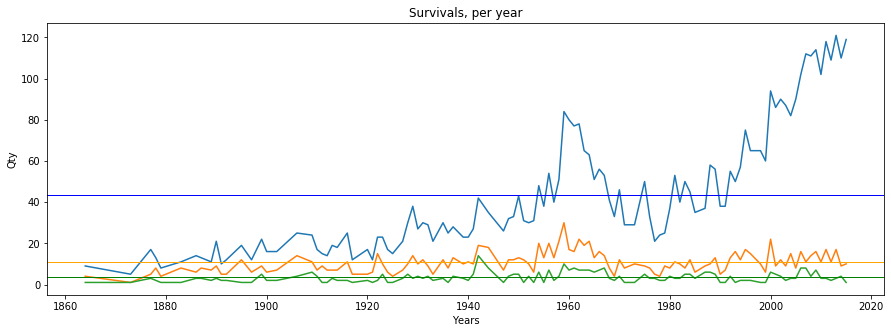

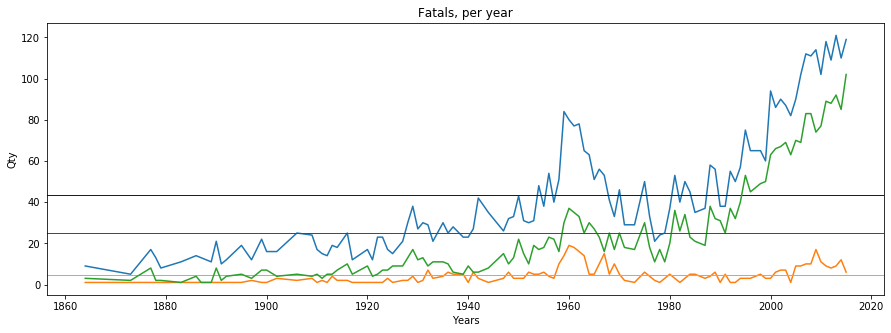

In [13]:
plt.figure(figsize=(15,5))
#TOTAL
mean = (sum(data_clean['Total_Ataks'])/len(data_clean['Total_Ataks']))
# axis x, axis y
y = data_clean['Total_Ataks']
x = data_clean['Year']

# plot 
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='blue')

#survival provoked
mean = (sum(data_clean['Survival-Provoked'])/len(data_clean['Survival-Provoked']))
# axis x, axis y
y = data_clean['Survival-Provoked']
x = data_clean['Year']

# plot
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='orange')

#Survival unprovoked
mean = (sum(data_clean['Survival-Unprovoked'])/len(data_clean['Survival-Unprovoked']))
# axis x, axis y
y = data_clean['Survival-Unprovoked']
x = data_clean['Year']

# plot
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='green')
plt.xlabel('Years')
plt.ylabel('Qty')
plt.title('Survivals, per year')

print('GRAPH1:\nBlue => Atacks \nOrange => Survivals-provoked \nGreen => Survivals-unprovoked')
plt.figure(figsize=(15,5))
#TOTAL
mean = (sum(data_clean['Total_Ataks'])/len(data_clean['Total_Ataks']))
# axis x, axis y
y = data_clean['Total_Ataks']
x = data_clean['Year']

# plot 
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='blue')

#Fatal provoked
mean = (sum(data_clean['Fatal-Provoked'])/len(data_clean['Fatal-Provoked']))
# axis x, axis y
y = data_clean['Fatal-Provoked']
x = data_clean['Year']

# plot
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='orange')

#Fatal unprovoked
mean = (sum(data_clean['Fatal-Unprovoked'])/len(data_clean['Fatal-Unprovoked']))
# axis x, axis y
y = data_clean['Fatal-Unprovoked']
x = data_clean['Year']

# plot
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='green')
plt.xlabel('Years')
plt.ylabel('Qty')
plt.title('Fatals, per year')
print('GRAPH2:\nBlue => Atacks \nOrange => Fatals-provoked \nGreen => Fatals-unprovoked')



En las gráficas se observa como el número total de ataques ha aumentado y se mantiene el nmero de supervivientes tanto de ataque provocado como no provocado.
En la siguiente gráfica esta representado el número total de ataques y los muertos y supervivientes.

Blue => Total Ataks
Green =>Survivals  
Orange => Fatals


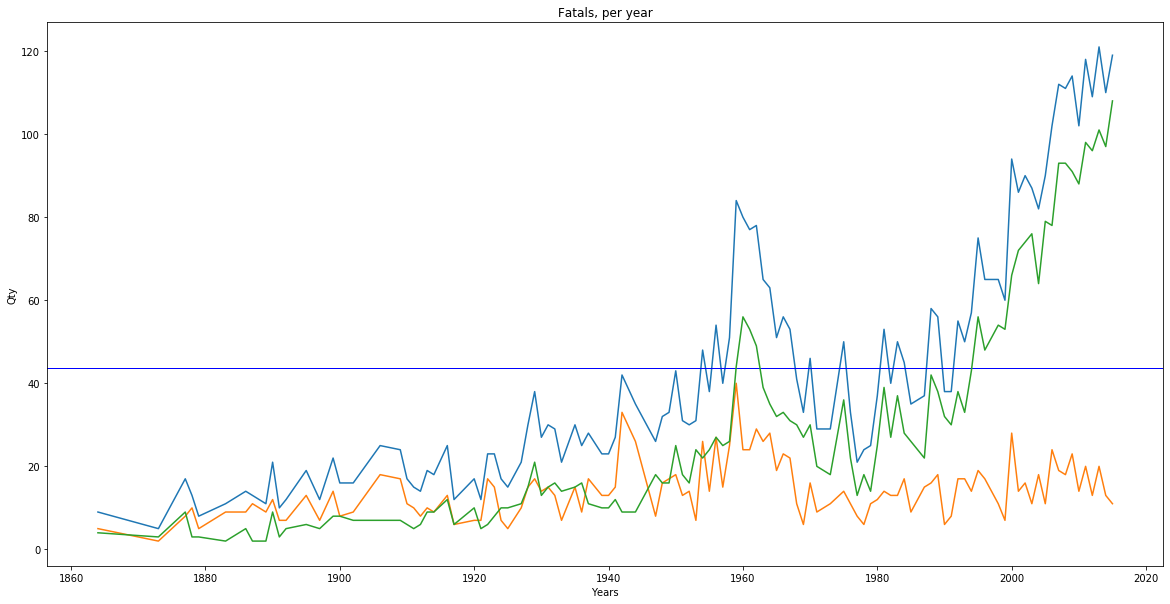

In [17]:
plt.figure(figsize=(20,10))
#TOTAL
mean = (sum(data_clean['Total_Ataks'])/len(data_clean['Total_Ataks']))
# axis x, axis y
y = data_clean['Total_Ataks']
x = data_clean['Year']

# plot 
plt.plot(x, y)
plt.axhline(y=mean, linewidth=1, color='blue')

#Survival
# axis x, axis y
y =  data_clean['Survival-Provoked']+data_clean['Survival-Unprovoked']
x = data_clean['Year']

# plot
plt.plot(x, y)

#Fatal
# axis x, axis y
y = data_clean['Fatal-Unprovoked']+data_clean['Fatal-Provoked']
x = data_clean['Year']

# plot
plt.plot(x, y)
plt.xlabel('Years')
plt.ylabel('Qty')
plt.title('Fatals, per year')
print('Blue => Total Ataks\nGreen =>Survivals  \nOrange => Fatals')

In [45]:
data_clean.to_csv("output/DataFrame_clean.csv",index = None)

## 4.- Hipóteis
Al finalizar el análisis con los datos obtenidos mi hipótesis se confirmae, dejando claro que el número de supervivientes ha aumentado con el paso de los años, he podido ver que en ataques provocados el número de supervivientes si es mayor que en ataques no provocados, esto puede ser debido a tener un mayor control de la situación y no ser tan impredecible como en un ataque no provocado.
Mi decisión para buscar datos de que el número de supervivientes en ataques es mayor con el paso de los años se basa en la evolución de la tecnología y la medicina.